# TAIAOexp

### Evaluation of explanation quality: saliency maps

Jesús Antoñanzas, under the supervision of Dr. Alvin Jia

<p float="left">
  <img src="https://www.bourses-etudiants.ma/wp-content/uploads/2018/06/University-of-Waikato-logo.png" alt="drawing" style="width:300px;"/>
  
  <img src="https://taiao.ai/img/6825_TAIAO_logo_1000x320.jpg" alt="drawing" style="width:250px;"/>
</p>

In this notebook, we are going to explore how we can use TAIAOexp to compare image explanation methods.

## 1. Evaluating synthetic image data explanations

In this section, we are going to 
1. Generate image data with available g.t. explanations using the 'seneca' method.
2. Create and train a pytorch classifier that will learn to recognize the pattern in the images.
3. Generate explanations with some model agnostic methods and evaluate them w.r.t. the ground truth explanations.

In [1]:
%cd ../../..

/home/ajia/TAIAOexp


In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import PIL
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from math import floor

from captum.attr import GradientShap, IntegratedGradients, Occlusion, DeepLift, Lime, GuidedBackprop, GuidedGradCam

from TAIAOexp.saliencyMap import gen_data_sm, saliency_map_scores
from TAIAOexp.utils._arrays import _minmax_normalize_array

### 1.1. Generating the data

In [3]:
cellH, cellW = 4, 4
imH, imW = 32, 32

X, y, exps, pat = gen_data_sm(method='seneca', imageH=imH, imageW=imW, 
                              cellH=cellH, cellW=cellW, nSamples=5000, randomState=7)

Text(0.5, 1.0, 'Explanation')

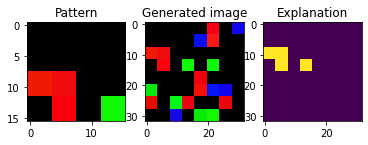

In [4]:
i = 2
fig, axs = plt.subplots(1, 3)
axs[0].imshow(pat)
axs[0].set_title('Pattern')
axs[1].imshow(X[i])
axs[1].set_title('Generated image')
axs[2].imshow(exps[i])
axs[2].set_title('Explanation')

### 1.2. Declaring and training the model

Declare a simple LeNet variant and its training routine.

In [63]:
class FCNN(nn.Module):
    """ Basic NN for image classification. """

    def __init__(self, imH, imW, cellH, randomState=1):
        super(FCNN, self).__init__()
        stride = 1
        kSize = 5
        torch.manual_seed(randomState)
        self.conv1 = nn.Conv2d(3, 6, kernel_size=kSize, stride=stride)
        self.H1, self.W1 = floor(((imH - kSize) / stride) + 1), floor(((imW - kSize) / stride) + 1)
        self.conv2 = nn.Conv2d(6, 3, kernel_size=kSize, stride=stride)
        self.H2, self.W2 = floor(((self.H1 - kSize) / stride) + 1), floor(((self.W1 - kSize) / stride) + 1)
        self.conv3 = nn.Conv2d(3, 1, kernel_size=kSize, stride=stride)
        self.H3, self.W3 = floor(((self.H2 - kSize) / stride) + 1), floor(((self.W2 - kSize) / stride) + 1)
        self.fc1 = nn.Linear(self.H3 * self.W3, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        if len(x.shape) == 3:
            # single instance, add the batch dimension
            x = x.unsqueeze(0)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.shape[0], -1)))
        x = self.fc2(x)
        return x
    
import copy
# sample training function for classification
def train_net(model, data, criterion, optimizer, device, batchSize, nEpochs, randomState=888):
    """ data: dict with 'train' and 'val' entries. Each entry is a list with X: FloatTensor, y: LongTensor """
    torch.manual_seed(randomState)
    bestValAcc = -np.inf
    bestModelWeights = copy.deepcopy(model.state_dict())
    for epoch in range(nEpochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            lossVal = .0
            corrects = 0
            
            for batch in range(int(len(data[phase][0]) / batchSize)):
                XBatch = data[phase][0][batch:batch + batchSize].to(device)
                yBatch = data[phase][1][batch:batch + batchSize].to(device)
                
                model.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):

                    out = model(XBatch)
                    loss = criterion(out, yBatch)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    _, preds = torch.max(out, 1)
                
                lossVal += loss.item() * XBatch.size(0)
                corrects += torch.sum(preds == yBatch.data)
            
            epochLoss = lossVal / len(data[phase][0])
            epochAcc = corrects.double() / len(data[phase][0])
            print(f'{phase} Loss: {round(epochLoss, 4)} Acc: {round(epochAcc.item(), 4)}')
        
            if phase == 'val' and epochAcc > bestValAcc:
                bestValAcc = epochAcc
                bestModelWeights = copy.deepcopy(model.state_dict())
        
        model.load_state_dict(bestModelWeights)
        
    return model, bestValAcc

We cast the images to torch.Tensor type and get train, validation and test splits.

In [6]:
XTrain, XTest, yTrain, yTest, expsTrain, expsTest = train_test_split(X, y, exps, train_size=0.8, random_state=7)
XTrain, XVal, yTrain, yVal, expsTrain, expsVal = train_test_split(XTrain, yTrain, expsTrain, train_size=0.75, random_state=7)

XTrain = torch.FloatTensor(XTrain).permute(0, 3, 1, 2)
yTrain = torch.LongTensor(yTrain)
XVal = torch.FloatTensor(XVal).permute(0, 3, 1, 2)
yVal = torch.LongTensor(yVal)
XTest = torch.FloatTensor(XTest).permute(0, 3, 1, 2)
yTest = torch.LongTensor(yTest)

In [7]:
print(f'Data proportions -> Train: {round(len(XTrain) / len(X), 3)}, Val: {round(len(XVal) / len(X), 3)}, Test: {round(len(XTest) / len(X), 3)}')
print(f'Positive label proportions -> Train: {round((sum(yTrain) / len(yTrain)).item(), 3)}, \
Val: {round((sum(yVal) / len(yVal)).item(), 3)}, Test: {round((sum(yTest) / len(yTest)).item(), 3)}')

Data proportions -> Train: 0.6, Val: 0.2, Test: 0.2
Positive label proportions -> Train: 0.489, Val: 0.526, Test: 0.507


and train the network

In [8]:
nFeatures = len(XTrain[0].flatten())
criterion = nn.CrossEntropyLoss()
model = FCNN(imH=32, imW=32, cellH=4)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
data = {'train': [XTrain, yTrain], 'val': [XVal, yVal]}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, valAcc = train_net(model, data, criterion, optimizer, device, batchSize=10, nEpochs=10, randomState=7)

train Loss: 0.526 Acc: 0.7693
val Loss: 0.4456 Acc: 0.911
train Loss: 0.203 Acc: 0.94
val Loss: 0.0605 Acc: 0.995
train Loss: 0.0416 Acc: 0.9923
val Loss: 0.0291 Acc: 0.995
train Loss: 0.0377 Acc: 0.993
val Loss: 0.0284 Acc: 0.995
train Loss: 0.0345 Acc: 0.9927
val Loss: 0.028 Acc: 0.995
train Loss: 0.0324 Acc: 0.9933
val Loss: 0.0302 Acc: 0.995
train Loss: 0.0317 Acc: 0.9933
val Loss: 0.029 Acc: 0.995
train Loss: 0.0299 Acc: 0.9937
val Loss: 0.0352 Acc: 0.995
train Loss: 0.0301 Acc: 0.993
val Loss: 0.0288 Acc: 0.995
train Loss: 0.0284 Acc: 0.994
val Loss: 0.0396 Acc: 0.995


In [9]:
print(f'Validation F1: {round(f1_score(yVal, F.softmax(model(torch.FloatTensor(XVal)), dim=-1).argmax(dim=1).detach().numpy()), 3)}')
print(f'Test F1: {round(f1_score(yTest, F.softmax(model(torch.FloatTensor(XTest)), dim=-1).argmax(dim=1).detach().numpy()), 3)}')

Validation F1: 0.988
Test F1: 0.983


### 1.3. Generating and evaluating explanations

With the model trained on the synthetic images, we generate explanations (with Captum, but feel free to use other methods!). First, declare the explainers:

In [10]:
gradShap = GradientShap(model)
intGrad = IntegratedGradients(model)
occlusion = Occlusion(model)
deepLift = DeepLift(model)
guidedBackProp = GuidedBackprop(model)
guidedGradCAM = GuidedGradCam(model, model.conv3)

And define a function to obtain the explanations from different methods:

In [3]:
def get_attributions(data, labels, explainer, params=None):
    """  
    :param data: (Tensor) data to explain
    :param labels: (Tensor) class labels w.r.t which we want to compute the attributions
    :param explainer: (captum.attr method) initialised explainer
    :param params: (dict) parameters for the .attribute method of the explainer 
    :return: ndarray of shape with attributions
    """
    
    if params is None:
        params = {}
    attributions = []
    for image, target in zip(data, labels):
        image = image.unsqueeze(0)
        attr = explainer.attribute(image, target=target, **params).squeeze().cpu().detach().numpy()
        # mean pool channel attributions
        attr = np.mean(attr, axis=0)
        # viz._normalize_image_attr(tmp, 'absolute_value', 10)
        attributions.append(_minmax_normalize_array(attr))

    return np.array(attributions)

In [ ]:
# takes some minutes to run
gradShapExpsTest = get_attributions(XTest[yTest == 1], yTest[yTest == 1], gradShap, {'baselines': torch.zeros((1, 3, imH, imW))})
intGradExpsTest = get_attributions(XTest[yTest == 1], yTest[yTest == 1], intGrad)
deepLiftExpsTest = get_attributions(XTest[yTest == 1], yTest[yTest == 1], deepLift)
occlusionExpsTest = get_attributions(XTest[yTest == 1], yTest[yTest == 1], occlusion, {'baselines': 0, 'sliding_window_shapes': (3, cellH*2, cellW*2)})
gBackPropExpsTest = get_attributions(XTest[yTest == 1], yTest[yTest == 1], guidedBackProp)
gGradCAMExpsTest = get_attributions(XTest[yTest == 1], yTest[yTest == 1], guidedGradCAM)

with open('TAIAOexp/_demos/notebooks/temp/expsSynth.pickle', 'wb') as handle:
    pickle.dump([gradShapExpsTest, intGradExpsTest, deepLiftExpsTest, occlusionExpsTest, gBackPropExpsTest, gGradCAMExpsTest], handle)

In [12]:
with open('TAIAOexp/_demos/notebooks/temp/expsSynth.pickle', 'rb') as handle:
    gradShapExpsTest, intGradExpsTest, deepLiftExpsTest, occlusionExpsTest,\
        gBackPropExpsTest, gGradCAMExpsTest = pickle.load(handle)

Text(0.5, 1.0, 'Guided gradCAM.')

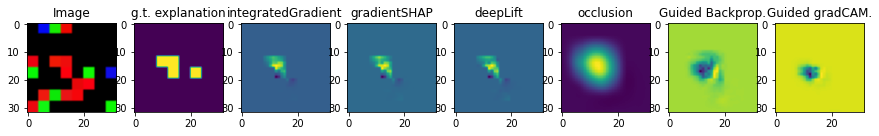

In [22]:
i = 10

fig, axs = plt.subplots(1, 8, figsize=(15,15))
axs[0].imshow(XTest[yTest == 1][i].permute(1, 2, 0))
axs[0].set_title('Image')
axs[1].imshow(expsTest[yTest == 1][i])
axs[1].set_title('g.t. explanation')
axs[2].imshow(intGradExpsTest[i])
axs[2].set_title('integratedGradient')
axs[3].imshow(gradShapExpsTest[i])
axs[3].set_title('gradientSHAP')
axs[4].imshow(deepLiftExpsTest[i])
axs[4].set_title('deepLift')
axs[5].imshow(occlusionExpsTest[i])
axs[5].set_title('occlusion')
axs[6].imshow(gBackPropExpsTest[i])
axs[6].set_title('Guided Backprop.')
axs[7].imshow(gGradCAMExpsTest[i])
axs[7].set_title('Guided gradCAM.')

And we can evaluate the explanations. We set the binarization threshold for the generated explanations to 0.5 because we only want high values to count.

In [23]:
metrics = ['auc', 'fscore', 'prec', 'rec', 'cs']
gradShapScores = saliency_map_scores(expsTest[yTest == 1], gradShapExpsTest, metrics=metrics, binThreshold=0.5)
intGradScores = saliency_map_scores(expsTest[yTest == 1], intGradExpsTest, metrics=metrics, binThreshold=0.5)
deepLiftScores = saliency_map_scores(expsTest[yTest == 1], deepLiftExpsTest, metrics=metrics, binThreshold=0.5)
occlusionScores = saliency_map_scores(expsTest[yTest == 1], occlusionExpsTest, metrics=metrics, binThreshold=0.5)
gBackPropScores = saliency_map_scores(expsTest[yTest == 1], gBackPropExpsTest, metrics=metrics, binThreshold=0.5)
gGradCAMScores = saliency_map_scores(expsTest[yTest == 1], gGradCAMExpsTest, metrics=metrics, binThreshold=0.5)

scores = pd.DataFrame(data=[gradShapScores, intGradScores, deepLiftScores, 
                            occlusionScores, gBackPropScores, gGradCAMScores], columns=metrics)
scores['technique'] = ['gradSHAP', 'intGrad', 'deepLift', 'occlusion', 'guidedBackProp', 'guidedGradCAM']
scores

/home/ajia/TAIAOexp/TAIAOexp/featureImportance.py:421: UserWarning: Binary prediction does not contain values != 0, so one entry is being flipped to 1 for the metrics to be defined.
  warnings.warn('Binary prediction does not contain values != 0, so one entry is being flipped to 1 for '
/home/ajia/TAIAOexp/TAIAOexp/featureImportance.py:430: UserWarning: Prediction does not contain values != 0, so 1e-4 is being added to one random entry in both.
  warnings.warn('Prediction does not contain values != 0, so 1e-4 is being added to one random entry '
/home/ajia/TAIAOexp/TAIAOexp/featureImportance.py:421: UserWarning: Binary prediction does not contain values != 0, so one entry is being flipped to 1 for the metrics to be defined.
  warnings.warn('Binary prediction does not contain values != 0, so one entry is being flipped to 1 for '
/home/ajia/TAIAOexp/TAIAOexp/featureImportance.py:430: UserWarning: Prediction does not contain values != 0, so 1e-4 is being added to one random entry in both.

,auc,fscore,prec,rec,cs,technique
0,0.790857,0.510689,0.985169,0.350592,0.379904,gradSHAP
1,0.807460,0.536130,0.996638,0.371918,0.384667,intGrad
2,0.805616,0.467340,0.992796,0.312623,0.359009,deepLift
3,0.914979,0.511099,0.391588,0.749969,0.578135,occlusion
4,0.139498,0.084781,0.045111,0.702971,0.187680,guidedBackProp
5,0.349901,0.109400,0.058152,0.921413,0.232646,guidedGradCAM


Note how the warnings tell us that the predictions from one of the techniques did not contain any relevant values. 

From here, we can build a more complex explanation evaluation pipeline. Suppose that, given some explainer architecture and model, we want to measure how the influence of some explainer hyperparameters influence the quality of their generated explanations.

In [4]:
def eval_explainers(explainers, explainerConfigs, data, labels, trueExps, metrics):
    """ 
    :param explainers: (dict of captum.attr explainers) explainers to use
    :param explainerConfigs: (dict of list of dict) hyperparameter values to use for each explainer (see Captum docs)
    :param data: (Tensor) data to explain
    :param labels: (Tensor) labels w.r.t. which we compute the explanations
    :param trueExps: (ndarray) ground truth explanations
    :param metrics: (array-like of str) metrics to compute
    """
    allScores = {explainer: {met: [] for met in metrics} for explainer in explainers.keys()}
    for explainerName, explainer in explainers.items():
        for config in explainerConfigs[explainerName]:
            exps = get_attributions(data, labels, explainer, config)
            evals = saliency_map_scores(trueExps, exps, metrics=metrics)
            for i, score in enumerate(evals):
                allScores[explainerName][metrics[i]].append(score)
    return allScores

for example, given these gradSHAP and guidedGradCAM configurations:

In [14]:
configs = {
    'gradSHAP': [{'baselines': torch.zeros((1, 3, imH, imW)), 'n_samples': 10, 'stdevs': 0.1},
                 {'baselines': torch.zeros((1, 3, imH, imW)), 'n_samples': 15, 'stdevs': 0.15}],
    'gradCAM': [{'interpolate_mode': 'nearest'},
                {'interpolate_mode': 'area'}]
}

explainers = {'gradSHAP': gradShap, 'gradCAM': guidedGradCAM}

metrics = ['auc', 'fscore', 'prec', 'rec', 'cs']

In [26]:
# takes some minutes to run
scores = eval_explainers(explainers, configs, XTest[yTest==1], yTest[yTest==1], expsTest[yTest==1], metrics)

with open('TAIAOexp/_demos/notebooks/temp/synthScores.pickle', 'wb') as f:
    pickle.dump(scores, f)

/home/ajia/.local/lib/python3.6/site-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/ajia/.local/lib/python3.6/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."
/home/ajia/.local/lib/python3.6/site-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/ajia/.local/lib/python3.6/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


In [27]:
with open('TAIAOexp/_demos/notebooks/temp/synthScores.pickle', 'rb') as f:
    scores = pickle.load(f)

For each explainer and configuration, we have a score:

In [28]:
scores

{'gradSHAP': {'auc': [0.79849994, 0.8019059],
  'fscore': [0.11596752, 0.11600501],
  'prec': [0.061611623, 0.061631564],
  'rec': [0.98471403, 0.9850222],
  'cs': [0.39063716, 0.39780653]},
 'gradCAM': {'auc': [0.34990147, 0.31682178],
  'fscore': [0.11693601, 0.11704486],
  'prec': [0.062125932, 0.062183756],
  'rec': [0.9929734, 0.9938979],
  'cs': [0.23264565, 0.23132235]}}

With these metrics, then, we can evaluate the performance of explainers.

## 2. Evaluating kahikatea image explanations

TAIAOexp includes real datasets with available ground truth explanations. For example, the Kahikatea dataset contains 519 images, and the task is to tell whether each observation contains Kahikatea trees or not. There are 232 positive observations and 287 negative ones.

In TAIAOexp, the non-artificial datasets are implemented as classes, similarly to PyTorch. After instancing the class, the data itself will be downloaded if it has not been used before. Once done, one can slice it to obtain observations. Each observation contains the data point, the label and the ground truth explanation.

In [76]:
from TAIAOexp.datasets import Kahikatea

In [87]:
nClasses = 2
kahikateaData = Kahikatea()
kData, kLabels, kExps = kahikateaData[:]

Text(0.5, 1.0, 'g.t. explanation')

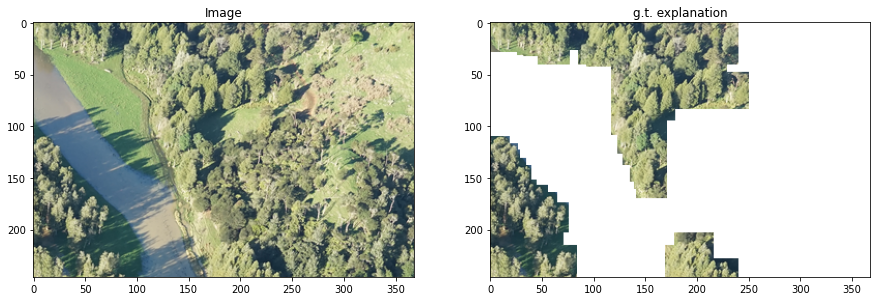

In [56]:
i = 0
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(kData[i])
axs[0].set_title('Image')
axs[1].imshow(kExps[i])
axs[1].set_title('g.t. explanation')

In [8]:
kahikateaData.classMap

{0: 'Not in image', 1: 'In image'}

Let's fine-tune a pre-trained squeezenet for our particular task.

In [65]:
sqznet = torch.hub.load('pytorch/vision:v0.9.0', 'squeezenet1_0', pretrained=True)
torch.manual_seed(7)

Using cache found in /home/ajia/.cache/torch/hub/pytorch_vision_v0.9.0


And modify its architecture so the shape of the output conforms to our 2-class problem instead of the 1000-class ImageNet.

In [66]:
sqznet.classifier[1] = nn.Conv2d(512, nClasses, kernel_size=(1,1), stride=(1,1))
sqznet.num_classes = nClasses
inputSize = 224

Define the required transform for the input images

In [59]:
from torchvision import transforms

inputTransform = transforms.Compose([transforms.Resize((inputSize, inputSize)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
resizeTransform = transforms.Compose([transforms.Resize((inputSize, inputSize)),
                                     transforms.ToTensor()])

Transform the data to torch tensors and create the splits:

In [88]:
kData = torch.stack([inputTransform(img) for img in kData])
kExps = torch.stack([resizeTransform(img) if isinstance(img, PIL.Image.Image) else torch.zeros((3, inputSize, inputSize)) for img in kExps]).permute(0, 2, 3, 1)
kExps = kExps.numpy().astype(np.float32)  # we need g.t. explanations to be numpy arrays for the evaluation
kLabels = torch.LongTensor(kLabels)

kTrain, kTest, kTrainLabels, kTestLabels, kExpsTrain, kExpsTest = train_test_split(kData, kLabels, kExps, train_size=0.8, random_state=7)
kTrain, kVal, kTrainLabels, kValLabels, kExpsTrain, kExpsVal = train_test_split(kTrain, kTrainLabels, kExpsTrain, train_size=0.75, random_state=7)

In [89]:
print(f'Data proportions -> Train: {round(len(kTrain) / len(kData), 3)}, Val: {round(len(kVal) / len(kData), 3)}, Test: {round(len(kTest) / len(kData), 3)}')
print(f'Positive label proportions -> Train: {round((sum(kTrainLabels) / len(kTrainLabels)).item(), 3)}, \
Val: {round((sum(kValLabels) / len(kValLabels)).item(), 3)}, Test: {round((sum(kTestLabels) / len(kTestLabels)).item(), 3)}')

Data proportions -> Train: 0.599, Val: 0.2, Test: 0.2
Positive label proportions -> Train: 0.444, Val: 0.519, Test: 0.385


In [ ]:
opt = optim.SGD(sqznet.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batchSize = 30
nEpochs = 15
data = {'train': [kTrain, kTrainLabels], 'val': [kVal, kValLabels]}

sqznet, valAcc = train_net(sqznet, data, crit, opt, device, batchSize, nEpochs, randomState=7)

with open('TAIAOexp/_demos/notebooks/temp/sqznetTrained.pickle', 'wb') as f:
    pickle.dump(sqznet.state_dict(), f)

In [68]:
with open('TAIAOexp/_demos/notebooks/temp/sqznetTrained.pickle', 'rb') as f:
    sqznet.load_state_dict(pickle.load(f))

In [71]:
print(f'Validation F1: {round(f1_score(kValLabels, F.softmax(sqznet(kVal), dim=-1).argmax(dim=1).detach().numpy()), 3)}')
print(f'Test F1: {round(f1_score(kTestLabels, F.softmax(sqznet(kTest), dim=-1).argmax(dim=1).detach().numpy()), 3)}')

Validation F1: 0.781
Test F1: 0.652


Now, let's evaluate the quality of the explanations:

In [72]:
kExplainers = {'gradSHAP': GradientShap(sqznet), 
              'gradCAM': GuidedGradCam(sqznet, sqznet.features[12]),
              'deepLift': DeepLift(sqznet),
              'backProp': GuidedBackprop(sqznet),
              'occlusion': Occlusion(sqznet),
              'intGrad': IntegratedGradients(sqznet)}

kConfigs = {
    'gradSHAP': [{'baselines': torch.zeros((1, 3, inputSize, inputSize)), 'n_samples': 5, 'stdevs': 0.1},
                 {'baselines': torch.zeros((1, 3, inputSize, inputSize)), 'n_samples': 5, 'stdevs': 0.2},
                 {'baselines': torch.zeros((1, 3, inputSize, inputSize)), 'n_samples': 5, 'stdevs': 0.3},
                 {'baselines': torch.zeros((1, 3, inputSize, inputSize)), 'n_samples': 15, 'stdevs': 0.1},
                 {'baselines': torch.zeros((1, 3, inputSize, inputSize)), 'n_samples': 25, 'stdevs': 0.1}],
    'gradCAM': [{'interpolate_mode': 'nearest'},
                {'interpolate_mode': 'area'}],
    'deepLift': [{}],
    'backProp': [{}],
    'occlusion': [{'baselines': 0, 'sliding_window_shapes': (3, round(inputSize/2), round(inputSize/2))},
                  {'baselines': 0, 'sliding_window_shapes': (3, round(inputSize/3), round(inputSize/3))},
                  {'baselines': 0, 'sliding_window_shapes': (3, round(inputSize/4), round(inputSize/4))},
                  {'baselines': 0, 'sliding_window_shapes': (3, round(inputSize/5), round(inputSize/5))}],
    'intGrad': [{'method': 'riemann_right'}, {'method': 'riemann_left'}, {'method': 'riemann_middle'}, 
                {'method': 'riemann_trapezoid'}, {'method': 'gausslegendre'}]
}

metrics = ['auc', 'fscore', 'prec', 'rec', 'cs']

Evaluate positive test explanations. Note that TAIAOexp implicitly handles the conversion of the RGB masks into 0-1 normalised grayscale masks (the shape of the g.t.s need to be (imH, imW, 3) for it to happen).

In [99]:
# TODO FIX: CONVERSION TO GRAYSCALE OF GT MASKS TURNS THEM TO 0

# takes some minutes to run
scoresK = eval_explainers(kExplainers, kConfigs, kTest[kTestLabels==1], kTestLabels[kTestLabels==1], kExpsTest[kTestLabels==1], metrics)

with open('TAIAOexp/_demos/notebooks/temp/kahikateaScores.pickle', 'wb') as f:
    pickle.dump(scoresK, f)

/home/ajia/TAIAOexp/TAIAOexp/saliencyMap.py:349: UserWarning: Binarizing 40 g.t. RGB masks.
  warnings.warn(f'Binarizing {gts.shape[0]} g.t. RGB masks.')
/home/ajia/TAIAOexp/TAIAOexp/featureImportance.py:417: UserWarning: Binary ground truth does not contain values != 0, so one entry is being flipped to 1 for the metrics to be defined.
  warnings.warn('Binary ground truth does not contain values != 0, so one entry is being flipped to 1 '
/home/ajia/TAIAOexp/TAIAOexp/featureImportance.py:426: UserWarning: Ground truth does not contain values != 0, so 1e-4 is being added to one random entry in both.
  warnings.warn('Ground truth does not contain values != 0, so 1e-4 is being added to one random entry '
/home/ajia/TAIAOexp/TAIAOexp/featureImportance.py:417: UserWarning: Binary ground truth does not contain values != 0, so one entry is being flipped to 1 for the metrics to be defined.
  warnings.warn('Binary ground truth does not contain values != 0, so one entry is being flipped to 1 '
/h

KeyboardInterrupt: 

In [ ]:
with open('TAIAOexp/_demos/notebooks/temp/kahikateaScores.pickle', 'rb') as f:
    scoresK = pickle.load(f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


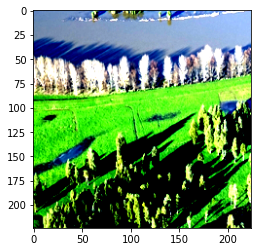

In [95]:
plt.imshow(kTest[kTestLabels==1][0].permute(1, 2, 0))

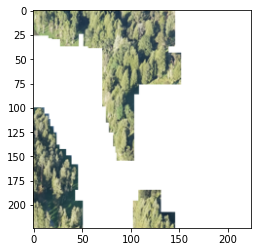

In [90]:
plt.imshow(kExps[0])

In [53]:
b = transforms.Resize((inputSize, inputSize))(kData[0])
np.unique(b)

array([ 22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 20

In [21]:
for im in kExpsTest[kTestLabels==1]:
    print(im.shape)
    if (im == 0).all():
        print('A')

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [26]:
kExpsTest[kTestLabels==1][1].max()

1